### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

### Load Data

In [3]:

def load_random_samples(filename, n_samples):
    df = pd.read_csv(filename)
    if len(df) > n_samples:
        return df.sample(n=n_samples, random_state=42)
    else:
        return df

# Chemins des dossiers
train_path = '/kaggle/input/ciciot2023/data/train'
test_path = '/kaggle/input/ciciot2023/data/test'

### Initialize Metric Lists

In [4]:
# Initialisation des listes pour stocker les métriques
DR_list_RF = []
FPR_list_RF = []
ACC_list_RF = []
DR_list_MI_RF = []
FPR_list_MI_RF = []
ACC_list_MI_RF = []
sample_count_list = []

### Load and Prepare Test Data

This section loads the test datasets for each attack class, assigns integer labels to each class, merges all test samples into a single test matrix and label array, and handles any missing or infinite values. This ensures the test data is clean and ready for model evaluation.

In [5]:
# Chargement des données de test 
benign_test = pd.read_csv(os.path.join(test_path, 'Benign_test.csv')).drop(columns=['Label'], errors='ignore')
ddos_test = pd.read_csv(os.path.join(test_path, 'DDoS_test.csv')).drop(columns=['Label'], errors='ignore')
dos_test = pd.read_csv(os.path.join(test_path, 'DoS_test.csv')).drop(columns=['Label'], errors='ignore')
mirai_test = pd.read_csv(os.path.join(test_path, 'Mirai_test.csv')).drop(columns=['Label'], errors='ignore')
recon_test = pd.read_csv(os.path.join(test_path, 'Recon_test.csv')).drop(columns=['Label'], errors='ignore')
spoofing_test = pd.read_csv(os.path.join(test_path, 'Spoofing_test.csv')).drop(columns=['Label'], errors='ignore')
webbased_test = pd.read_csv(os.path.join(test_path, 'Web-based_test.csv')).drop(columns=['Label'], errors='ignore')
bruteforce_test = pd.read_csv(os.path.join(test_path, 'Brute_Force_test.csv')).drop(columns=['Label'], errors='ignore')

# Création des labels de test
benign_test_labels = np.zeros(len(benign_test), dtype=int)
ddos_test_labels = np.ones(len(ddos_test), dtype=int)
dos_test_labels = np.full(len(dos_test), 2, dtype=int)
mirai_test_labels = np.full(len(mirai_test), 3, dtype=int)
recon_test_labels = np.full(len(recon_test), 4, dtype=int)
spoofing_test_labels = np.full(len(spoofing_test), 5, dtype=int)
webbased_test_labels = np.full(len(webbased_test), 6, dtype=int)
bruteforce_test_labels = np.full(len(bruteforce_test), 7, dtype=int)

# Fusion des données de test
TestMatrix = pd.concat([
    benign_test, ddos_test, dos_test, mirai_test,
    recon_test, spoofing_test, webbased_test, bruteforce_test
], ignore_index=True)
TestLabels = np.concatenate([
    benign_test_labels, ddos_test_labels, dos_test_labels, mirai_test_labels,
    recon_test_labels, spoofing_test_labels, webbased_test_labels, bruteforce_test_labels
])

# Gestion des valeurs infinies et manquantes pour le test
TestMatrix.replace([np.inf, -np.inf], np.nan, inplace=True)
TestMatrix.fillna(TestMatrix.mean(), inplace=True)

### Training and Evaluation Loop

This section iterates over different training set sizes (by varying the multiplier P), loads and prepares the corresponding training data and labels for each class, handles missing and infinite values, and then trains and evaluates two models:
- A standard Random Forest (RF)
- A Random Forest using the top 20 features selected by mutual information (MI+RF)

For each configuration, the code computes and prints the Detection Rate (DR), False Positive Rate (FPR), and Accuracy (ACC) for both methods, and saves these metrics for later analysis and visualization.

In [6]:

# Boucle sur P de 1 à 6
for P in range(1, 7):
    # Chargement des données d'entraînement avec P actuel
    benign_train = load_random_samples(os.path.join(train_path, 'Benign_train.csv'), 7100*P).drop(columns=['Label'], errors='ignore')
    ddos_train = load_random_samples(os.path.join(train_path, 'DDoS_train.csv'), 8600*P).drop(columns=['Label'], errors='ignore')
    dos_train = load_random_samples(os.path.join(train_path, 'DoS_train.csv'), 4160*P).drop(columns=['Label'], errors='ignore')
    mirai_train = load_random_samples(os.path.join(train_path, 'Mirai_train.csv'),2000*P).drop(columns=['Label'], errors='ignore')
    recon_train = load_random_samples(os.path.join(train_path, 'Recon_train.csv'), 3000*P).drop(columns=['Label'], errors='ignore')
    spoofing_train = load_random_samples(os.path.join(train_path, 'Spoofing_train.csv'), 6600*P).drop(columns=['Label'], errors='ignore')
    webbased_train = load_random_samples(os.path.join(train_path, 'Web-based_train.csv'), 190*P).drop(columns=['Label'], errors='ignore')
    bruteforce_train = load_random_samples(os.path.join(train_path, 'Brute_Force_train.csv'), 173*P).drop(columns=['Label'], errors='ignore')

    # Création des labels d'entraînement
    benign_labels = np.zeros(len(benign_train), dtype=int)
    ddos_labels = np.ones(len(ddos_train), dtype=int)
    dos_labels = np.full(len(dos_train), 2, dtype=int)
    mirai_labels = np.full(len(mirai_train), 3, dtype=int)
    recon_labels = np.full(len(recon_train), 4, dtype=int)
    spoofing_labels = np.full(len(spoofing_train), 5, dtype=int)
    webbased_labels = np.full(len(webbased_train), 6, dtype=int)
    bruteforce_labels = np.full(len(bruteforce_train), 7, dtype=int)

    # Fusion des données d'entraînement
    TrainMatrix = pd.concat([
        benign_train, ddos_train, dos_train, mirai_train,
        recon_train, spoofing_train, webbased_train, bruteforce_train
    ], ignore_index=True)
    TrainLabels = np.concatenate([
        benign_labels, ddos_labels, dos_labels, mirai_labels,
        recon_labels, spoofing_labels, webbased_labels, bruteforce_labels
    ])

    # Gestion des valeurs infinies et manquantes pour l'entraînement
    TrainMatrix.replace([np.inf, -np.inf], np.nan, inplace=True)
    TrainMatrix.fillna(TrainMatrix.mean(), inplace=True)

    # --- Méthode Random Forest standard ---
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(TrainMatrix, TrainLabels)
    pred_labels = rf.predict(TestMatrix)

    # Calcul métriques pour RF standard
    conf_mat = confusion_matrix(TestLabels, pred_labels, labels=np.unique(TestLabels))
    TP = np.diag(conf_mat)
    FN = np.sum(conf_mat, axis=1) - TP
    FP = np.sum(conf_mat, axis=0) - TP
    TN = np.sum(conf_mat) - (TP + FP + FN)

    DR_RF = np.mean(TP / (TP + FN)) * 100
    FPR_RF = np.mean(FP / (FP + TN)) * 100
    ACC_RF = np.sum(TP) / np.sum(conf_mat) * 100

    # --- Méthode MI + RF ---
    # Configuration de SelectKBest avec l'information mutuelle
    k = 20  # Nombre de caractéristiques à sélectionner
    selector = SelectKBest(score_func=mutual_info_classif, k=k)

    # Appliquer la sélection aux données d'entraînement
    TrainMatrix_reduced = selector.fit_transform(TrainMatrix, TrainLabels)

    # Transformer les données de test avec la même sélection
    TestMatrix_reduced = selector.transform(TestMatrix)

    # Entraînement RF sur caractéristiques sélectionnées
    rf_mi = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_mi.fit(TrainMatrix_reduced, TrainLabels)
    pred_labels_mi = rf_mi.predict(TestMatrix_reduced)

    # Calcul métriques pour MI+RF
    conf_mat_mi = confusion_matrix(TestLabels, pred_labels_mi, labels=np.unique(TestLabels))
    TP_mi = np.diag(conf_mat_mi)
    FN_mi = np.sum(conf_mat_mi, axis=1) - TP_mi
    FP_mi = np.sum(conf_mat_mi, axis=0) - TP_mi
    TN_mi = np.sum(conf_mat_mi) - (TP_mi + FP_mi + FN_mi)

    DR_MI_RF = np.mean(TP_mi / (TP_mi + FN_mi)) * 100
    FPR_MI_RF = np.mean(FP_mi / (FP_mi + TN_mi)) * 100
    ACC_MI_RF = np.sum(TP_mi) / np.sum(conf_mat_mi) * 100

    print(f"P={P}:")
    print(f"  RF - DR={DR_RF:.2f}%, FPR={FPR_RF:.2f}%, ACC={ACC_RF:.2f}%")
    print(f"  MI+RF - DR={DR_MI_RF:.2f}%, FPR={FPR_MI_RF:.2f}%, ACC={ACC_MI_RF:.2f}%")

    # Sauvegarde des métriques
    DR_list_RF.append(DR_RF)
    FPR_list_RF.append(FPR_RF)
    ACC_list_RF.append(ACC_RF)
    DR_list_MI_RF.append(DR_MI_RF)
    FPR_list_MI_RF.append(FPR_MI_RF)
    ACC_list_MI_RF.append(ACC_MI_RF)
    sample_count_list.append(len(TrainMatrix))



P=1:
  RF - DR=77.43%, FPR=0.19%, ACC=98.54%
  MI+RF - DR=82.91%, FPR=0.19%, ACC=98.61%
P=2:
  RF - DR=82.33%, FPR=0.17%, ACC=98.77%
  MI+RF - DR=85.94%, FPR=0.16%, ACC=98.82%
P=3:
  RF - DR=85.54%, FPR=0.15%, ACC=98.92%
  MI+RF - DR=88.78%, FPR=0.13%, ACC=99.01%
P=4:
  RF - DR=89.19%, FPR=0.12%, ACC=99.08%
  MI+RF - DR=91.19%, FPR=0.11%, ACC=99.18%
P=5:
  RF - DR=91.86%, FPR=0.11%, ACC=99.23%
  MI+RF - DR=93.34%, FPR=0.09%, ACC=99.31%
P=6:
  RF - DR=94.08%, FPR=0.08%, ACC=99.38%
  MI+RF - DR=95.05%, FPR=0.07%, ACC=99.48%


### Plot Performance Metrics

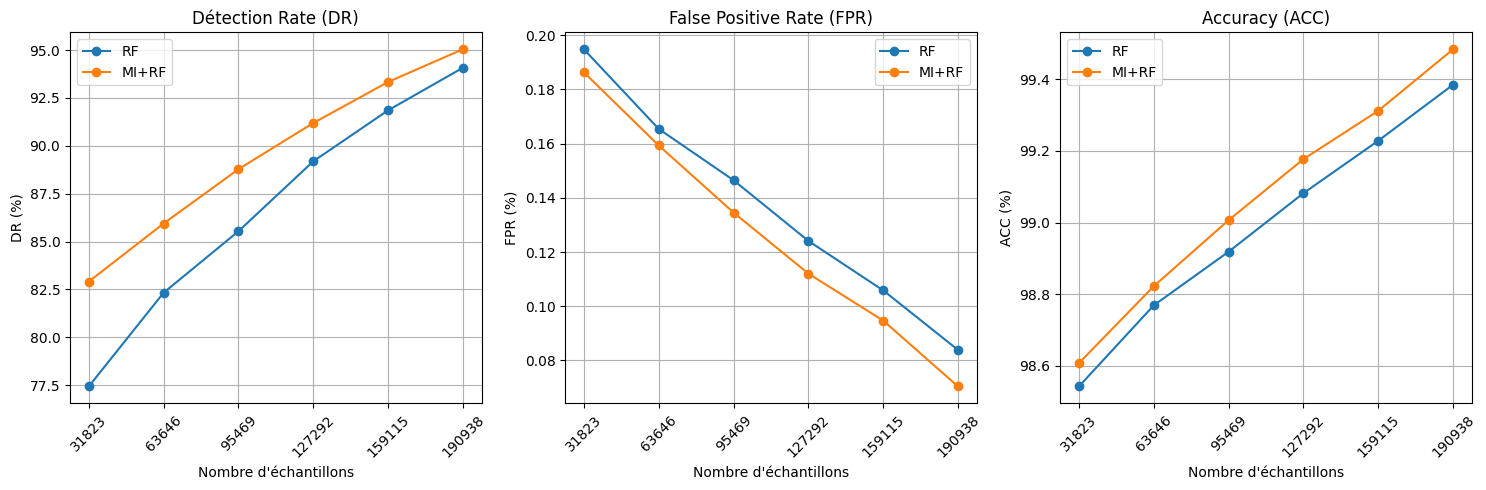

In [7]:
plt.figure(figsize=(15, 5))

# DR comparison
plt.subplot(1, 3, 1)
plt.plot(sample_count_list, DR_list_RF, marker='o', label="RF")
plt.plot(sample_count_list, DR_list_MI_RF, marker='o', label="MI+RF")
plt.xlabel("Nombre d'échantillons")
plt.ylabel("DR (%)")
plt.title("Détection Rate (DR)")
plt.legend()
plt.grid(True)
plt.xticks(sample_count_list, rotation=45)
plt.locator_params(axis='x', nbins=len(sample_count_list))

# FPR comparison
plt.subplot(1, 3, 2)
plt.plot(sample_count_list, FPR_list_RF, marker='o', label="RF")
plt.plot(sample_count_list, FPR_list_MI_RF, marker='o', label="MI+RF")
plt.xlabel("Nombre d'échantillons")
plt.ylabel("FPR (%)")
plt.title("False Positive Rate (FPR)")
plt.legend()
plt.grid(True)
plt.xticks(sample_count_list, rotation=45)
plt.locator_params(axis='x', nbins=len(sample_count_list))

# ACC comparison
plt.subplot(1, 3, 3)
plt.plot(sample_count_list, ACC_list_RF, marker='o', label="RF")
plt.plot(sample_count_list, ACC_list_MI_RF, marker='o', label="MI+RF")
plt.xlabel("Nombre d'échantillons")
plt.ylabel("ACC (%)")
plt.title("Accuracy (ACC)")
plt.legend()
plt.grid(True)
plt.xticks(sample_count_list, rotation=45)
plt.locator_params(axis='x', nbins=len(sample_count_list))

plt.tight_layout()
plt.show()